In [50]:
%matplotlib inline

import sys, io
import numpy as np
from collections import defaultdict as ddict
from gensim.models import KeyedVectors
import pythainlp as pyt
import clean
from attention import AttentionWithContext as att
from keras.models import model_from_json
import matplotlib.pyplot as plt
import dill as pickle

import tensorflow as tf
from keras import backend as K

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

In [2]:
vector_model_dir = '../model/'
vector_model_path_bin = f'{vector_model_dir}vec.bin'
vector_model = KeyedVectors.load_word2vec_format(vector_model_path_bin, binary=True)

itos = vector_model.index2word
stoi = ddict(lambda: 0, {v:k for k,v in enumerate(itos)})

In [3]:
print('Loading model from disk...')
date = '20190712_121844'
model_json = f'../model/model_{date}.json'
model_weights = f'../model/model_{date}.h5'
with open(model_json, 'r') as json_file:
    model = model_from_json(json_file.read(), custom_objects={'AttentionWithContext': att})
model.load_weights(model_weights)
print('Loading model from disk sucessfully')

Loading model from disk...
Loading model from disk sucessfully


In [4]:
input_len = 600
pad_token = '_pad_'
unk_token = '_unk_'

def sub_space(tok_sentence):
	return list(map(lambda token: '_space_' if token == ' ' else token, tok_sentence))
def sub_lol(tok_sentence):
	return list(map(lambda token: '_lol_' if token == 'lol' else token, tok_sentence))
def pad_sentence(tok_sentence):
	if len(tok_sentence) > input_len:
		return tok_sentence[:input_len]
	else:
		return tok_sentence + [pad_token] * (input_len - len(tok_sentence))
def sen2int(tok_list):
	tok_sentence = np.array(tok_list)
	new_int_sentence = []
	for list_tok in tok_sentence:
		tmp = []
		list_tok = sub_space(list_tok)
		list_tok = sub_lol(list_tok)
		list_tok = pad_sentence(list_tok)
		for tok in list_tok:
			if tok in itos:
				tmp.append(stoi[tok])
			else:
				tmp.append(stoi[unk_token])
		new_int_sentence.append(tmp)
	return new_int_sentence

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 300)          19500000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600, 300)          405900    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 600, 256)          329472    
_________________________________________________________________
attention_with_context_2 (At (None, 256)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total para

In [7]:

[x_train, x_test, y_train, y_test] = np.load('../dataset/train_test_data.npy')
x_train = x_train.astype('int32')
x_test = x_test.astype('int32')
print(x_train.shape, y_train.shape)
print(x_train.dtype, y_train.dtype)
print(x_test.shape, y_test.shape)
print(x_test.dtype, y_test.dtype)

print(f'pos size = { len(y_test[np.where( y_test[:,0] == 0 )]) }')
print(f'neg size = { len(y_test[np.where( y_test[:,0] == 1 )]) }')

word_vec = np.load('../model/vec.npy')

print(K.floatx()) # should equal float32

(34912, 600) (34912, 2)
int32 int32
(6161, 600) (6161, 2)
int32 int32
pos size = 3224
neg size = 2937
float32


In [20]:
x_all = np.concatenate((x_train, x_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# y_predict = model.predict_classes(x_all) 

pad_i = stoi[pad_token]
# print(x_all[0])
# print(np.where(x_all[0] == pad_i)[0])
get_first_pad_idx = lambda elem: np.where(elem == pad_i)[0]

x_all_nopad = list(map(lambda elem: np.delete(elem, get_first_pad_idx(elem)), x_all))
# print(x_all_nopad[0])

x_len = list(map(lambda x: len(x), x_all_nopad))
print(x_len)

[75, 104, 544, 23, 50, 101, 39, 14, 9, 171, 65, 20, 229, 22, 239, 70, 167, 235, 57, 18, 13, 7, 150, 114, 25, 68, 16, 23, 19, 7, 8, 399, 4, 89, 81, 22, 575, 1, 47, 151, 16, 383, 11, 9, 6, 99, 11, 33, 87, 13, 6, 11, 26, 118, 126, 169, 28, 51, 277, 36, 224, 157, 14, 38, 203, 36, 37, 3, 16, 78, 101, 6, 188, 75, 182, 8, 312, 122, 5, 42, 22, 10, 23, 35, 66, 15, 83, 18, 1, 178, 28, 80, 11, 18, 47, 83, 237, 20, 20, 10, 116, 21, 25, 27, 21, 66, 131, 5, 5, 185, 69, 98, 124, 14, 6, 11, 6, 178, 54, 97, 6, 95, 20, 13, 4, 49, 6, 12, 8, 78, 19, 81, 16, 8, 65, 16, 274, 84, 6, 11, 30, 13, 16, 20, 8, 12, 6, 3, 68, 12, 9, 226, 8, 18, 20, 42, 124, 7, 32, 101, 4, 36, 29, 90, 108, 23, 34, 6, 6, 57, 32, 6, 102, 14, 3, 23, 4, 310, 58, 10, 12, 16, 5, 268, 5, 6, 11, 54, 526, 8, 26, 54, 108, 118, 25, 81, 78, 63, 8, 68, 37, 12, 67, 6, 74, 146, 87, 16, 78, 74, 14, 13, 122, 17, 380, 15, 61, 12, 9, 89, 32, 44, 9, 76, 203, 6, 39, 31, 21, 25, 7, 94, 9, 121, 70, 69, 25, 3, 16, 12, 134, 1, 27, 7, 5, 600, 68, 79, 6, 44, 

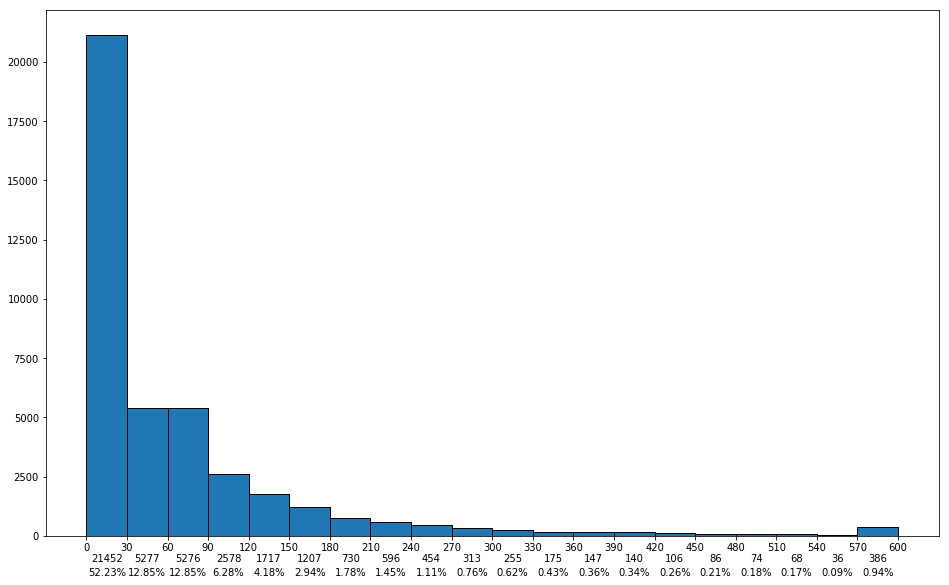

In [135]:
bins = [x for x in range(0, 600,30)]
# print(bins)

# plt.hist(x_len, bins=bins, range=(1,600))

fig, ax = plt.subplots(figsize=(16, 10))
counts, bins, patches = ax.hist(x_len, bins=range(0,601,30), range=(1,600), edgecolor='black')

x_len_mapped = list(map(lambda x: int((x-1)/30), x_len))
new_counts = [0]*(max(x_len_mapped)+1)     
for x in x_len_mapped:
    new_counts[x] += 1

ax.set_xticks(bins)

bin_centers = 0.5 * np.diff(bins) + bins[:-1]
for count, x in zip(new_counts, bin_centers):
    # Label the raw counts
    ax.annotate(str(int(count)), xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -18), textcoords='offset points', va='top', ha='center')

    # Label the percentages
    percent = '%0.2f%%' % (100 * float(count) / sum(new_counts))
    ax.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')


# Give ourselves some more room at the bottom of the plot
plt.subplots_adjust(bottom=0.15)

In [47]:
y_predict_all = model.predict_classes(x_all)

In [49]:
print(y_predict_all)
np.save('bgru_attn.npy', y_predict_all)

[1 0 1 ... 0 1 1]


In [179]:
print('Loading model from disk...')
date = '20190305_090338'
prefix_dir = 'result/gru_attn/'
model_json = f'../model/{prefix_dir}model_{date}.json'
model_weights = f'../model/{prefix_dir}model_{date}.h5'
with open(model_json, 'r') as json_file:
    model = model_from_json(json_file.read(), custom_objects={'AttentionWithContext': att})
model.load_weights(model_weights)
print('Loading model from disk sucessfully')

Loading model from disk...
Loading model from disk sucessfully


In [180]:
y_predict_all_cnn = model.predict_classes(x_all)
np.save('predicted/gru_attn.npy', y_predict_all_cnn)

In [181]:
from glob import glob

fileList = glob('predicted/*.npy')
dp = {}
for file in fileList:
    name = (file.split('\\')[-1]).split('.')[0]
    dp[name] = np.load(file)
# print(dp)
# print(x_len)

get_val = lambda arr: list(map(lambda x: x[1], arr))
y_true = get_val(y_all)

# res = list(map(lambda x: x[0]==x[1], zip(y_true, list(dp['bgru_attn']))))
# print(res.count(True)/len(res))

In [182]:
def create_bins():
    bins_template = {}
    for i in range(1,600,30):
        bins_template[f'{i}~{i+29}'] = 0
    return bins_template

# x_t = [1,29,30,31,59,60,61,89,90,91,570,571,600]
x_len_mapped = list(map(lambda x: int((x-1)/30), x_len))
# print(x_len_mapped)

df = {}
for (k,v) in dp.items():
    df[k] = [0]*(max(x_len_mapped)+1)
    
# map result to boolean
dp_boolean = {}
for key in dp.keys():
    dp_boolean[key] = list(map(lambda x: x[0]==x[1], zip(y_true, list(dp[key]))))

# put true into right bins
for k, v_list in dp_boolean.items():
    for idx, v in enumerate(v_list):
        if v:
            df[k][x_len_mapped[idx]] += 1
            
            
print(df)

new_counts = [0]*(max(x_len_mapped)+1)     
for x in x_len_mapped:
    new_counts[x] += 1
print(new_counts)

{'bgru': [20485, 5189, 5233, 2555, 1694, 1200, 725, 593, 452, 313, 255, 175, 147, 138, 106, 85, 74, 68, 36, 381], 'cnn': [20723, 5200, 5233, 2559, 1694, 1200, 723, 591, 453, 313, 254, 174, 144, 139, 106, 85, 74, 68, 36, 381], 'gru_attn': [20459, 5177, 5223, 2556, 1693, 1199, 720, 591, 452, 313, 255, 175, 145, 137, 106, 86, 74, 68, 36, 380]}
[21452, 5277, 5276, 2578, 1717, 1207, 730, 596, 454, 313, 255, 175, 147, 140, 106, 86, 74, 68, 36, 386]


In [183]:
print(df['bgru'])
print(list(map(int, new_counts)))

print(len(df['bgru']))

res = {}
for k,v in df.items():
    res[k] = list(map(lambda x, y: x/y, v, new_counts))
print(res)

[20485, 5189, 5233, 2555, 1694, 1200, 725, 593, 452, 313, 255, 175, 147, 138, 106, 85, 74, 68, 36, 381]
[21452, 5277, 5276, 2578, 1717, 1207, 730, 596, 454, 313, 255, 175, 147, 140, 106, 86, 74, 68, 36, 386]
20
{'bgru': [0.9549226179377214, 0.9833238582527951, 0.9918498862774829, 0.9910783553141971, 0.9866045428072219, 0.9942004971002486, 0.9931506849315068, 0.9949664429530202, 0.9955947136563876, 1.0, 1.0, 1.0, 1.0, 0.9857142857142858, 1.0, 0.9883720930232558, 1.0, 1.0, 1.0, 0.9870466321243523], 'cnn': [0.9660171545776618, 0.9854083759711958, 0.9918498862774829, 0.9926299456943367, 0.9866045428072219, 0.9942004971002486, 0.9904109589041096, 0.9916107382550335, 0.9977973568281938, 1.0, 0.996078431372549, 0.9942857142857143, 0.9795918367346939, 0.9928571428571429, 1.0, 0.9883720930232558, 1.0, 1.0, 1.0, 0.9870466321243523], 'gru_attn': [0.9537106097333582, 0.9810498389236308, 0.9899545109931767, 0.991466252909232, 0.9860221316249272, 0.9933719966859983, 0.9863013698630136, 0.99161073825

['1~30', '31~60', '61~90', '91~120', '121~150', '151~180', '181~210', '211~240', '241~270', '271~300', '301~330', '331~360', '361~390', '391~420', '421~450', '451~480', '481~510', '511~540', '541~570', '571~600']


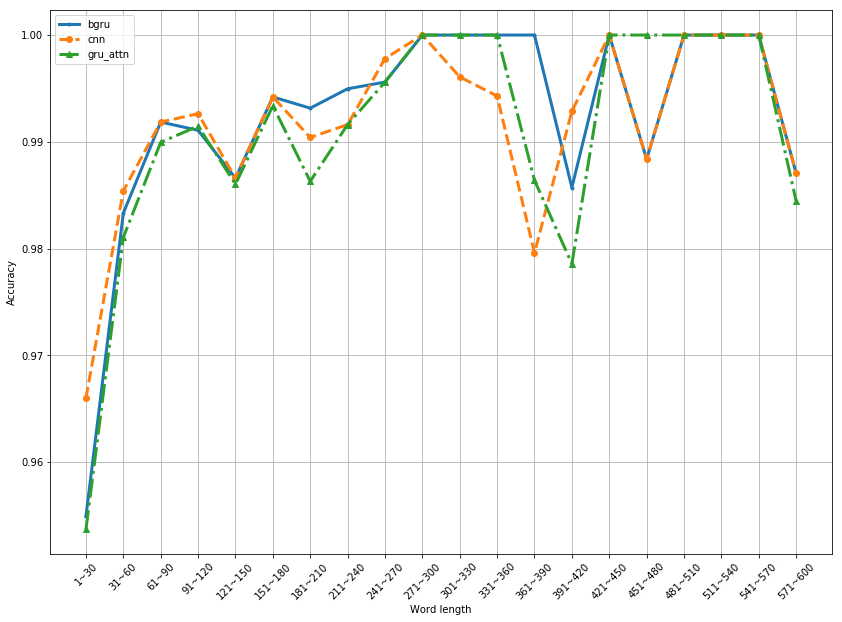

In [184]:
xticks = [f'{i}~{i+29}' for i in range(1,601,30)]

mk = ['.-', 'o--', '^-.', 'v:', '_-']
fmt = {}
for idx, k in enumerate(res.keys()):
    fmt[k] = mk[idx]

x_axis = list(range(0,20))
fig1, ax1 = plt.subplots(figsize=(14, 10))
for k,v in res.items():
    ax1.plot(x_axis, v, fmt[k], label=f'{k}', linewidth=3)
leg = ax1.legend(loc='upper left')
plt.xticks([i for i in range(20)], xticks, rotation=45)
ax1.set_xlabel("Word length")
ax1.set_ylabel("Accuracy")

ax1.xaxis.grid()
ax1.yaxis.grid()

plt.show()